In [128]:
%reset

In [129]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [130]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNLE, SNPE#, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
from joblib import Parallel, delayed, parallel_backend
from scipy.integrate import quad, simpson
import pickle
from scipy.stats import norm
import sources.DMsignal as DMsignal
import sources.FermiBackgrounds as FermiBackgrounds
from astropy import units as u


%matplotlib inline

In [131]:
grains=1000
num_simulations = 1000
num_workers = 48

In [132]:
parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1000, 100000] #MeV 
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5] # MeV
# max_radius = 8.5 + 20*2 #kpc
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut_degrees = 180 #degrees # 180 degress is full sky
angular_cut = angular_cut_degrees*u.deg.to('rad') # radians
angular_cut_gen =  min(angular_cut*1.5, np.pi) # radians
lat_cut_degrees = 30 #degrees # 0 degrees is full sky
lat_cut = lat_cut_degrees*u.deg.to('rad') # radians
lat_cut_gen = lat_cut*0.5 # radians

In [133]:
my_cosmology = 'Planck18'
# z_range = [0, 14]
luminosity_range = 10.0**np.array([33, 53]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.
                                            # Maximum value set by that value of luminosity that suffieciently suppreses the luminoisity function at the higher end of the luminosity range.
# AEGIS object for Dark matter signal
def build_aegis_object():
    engine = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut , lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, verbose = False)
    engine.angular_cut_gen, engine.lat_cut_gen = angular_cut_gen, lat_cut_gen
    return engine


Background signal

In [134]:
# Add Fermi isotropic background source class
data_root = '/home/users/ids29/DGRB'
my_FB = FermiBackgrounds.FermiBackgrounds(data_root)
def spec_iso_wrap(energy, params):
    A_BG = params[0]
    iso_fit = my_FB.get_isotropic_background_spectrum_func()
    correction_normalization = 1.6168325498644325 # this factor adjusts the normalization such that the number of photons in this faux isotropic background is equal to the sum of number of photons in the Fermi isotropic background,
                               # and the number of photons in the Fermi non-isotropic background.
    return A_BG * iso_fit(energy) * correction_normalization

In [135]:
als_FIB = [spec_iso_wrap]

In [136]:
# a simple simulator with the total number of photons as the summary statistic
def simulator(my_AEGIS, params):

    input_params = params.numpy()

    source_info = my_AEGIS.create_sources(input_params, grains=grains, epsilon=1e-2)
    photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info, grains=grains) 
    obs_info = {'psf_fits_path': '/home/users/ids29/DGRB/FERMI_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '/home/users/ids29/DGRB/FERMI_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    obs_photon_info = my_AEGIS.mock_observe(photon_info, obs_info)
    
    return obs_photon_info

Isotropic Background signal

In [137]:
# # Add Fermi isotropic background source class
# data_root = '/home/users/ids29/DGRB'
# my_FB = FermiBackgrounds.FermiBackgrounds(data_root)
# def spec_iso_wrap(energy, params):
#     A_BG = params[0]
#     iso_fit = my_FB.get_isotropic_background_spectrum_func()
#     return A_BG * iso_fit(energy)

# als_FIB = [spec_iso_wrap]

In [ ]:
# # Instatantiate the AEGIS object
# obj_AEGIS = build_aegis_object()

# # Configure the AEGIS object for Background
# obj_AEGIS.abun_lum_spec =  [als_FIB] 
# obj_AEGIS.source_class_list = ['isotropic_diffuse']

# # Run the simulator for Background data
# A_BG_test = 1.0 # This is the normalization factor for the isotropic background
# params_BG = torch.tensor([A_BG_test])
# photon_info_BG = simulator(obj_AEGIS, params_BG)

# ## Output Result:
# # Number of photons in region of interest for Fermi isotropic background = 145_002

Non-isotropic Background signal

In [139]:
data_root = '/home/users/ids29/DGRB'
my_FB      = FermiBackgrounds.FermiBackgrounds(data_root)

def spec_non_iso_wrap(params):
    """
    Returns (vals, E_edges, pix_idx, nside) in the format AEGIS expects
    for a 'healpix_map' source.  The `params` argument is ignored – it is
    only present because AEGIS will pass the global parameter vector in.
    """
    nside        = 64                     # keep it power-of-2 (same as AEGIS default)
    ang_cut      = angular_cut_gen   # reuse whatever ROI you set earlier
    Emin, Emax   = energy_range_gen[0], energy_range_gen[1] # MeV
    N_Ebins      = 10                     # or any number of energy slices you like

    vals, E_edges, pix_idx = my_FB.get_partial_nonistropic_background(
                                angular_cut = ang_cut,
                                Emin        = Emin,
                                Emax        = Emax,
                                N_Ebins     = N_Ebins,
                                N_side      = nside)
    return vals, E_edges, pix_idx, nside

als_non_iso_background = [spec_non_iso_wrap]

In [ ]:
# Instatantiate the AEGIS object
obj_AEGIS = build_aegis_object()

# Configure the AEGIS object for Background
obj_AEGIS.abun_lum_spec =  [als_non_iso_background] 
obj_AEGIS.source_class_list = ['healpix_map']

# Run the simulator for Background data
A_BG_test = 1.0 # This is the normalization factor for the non-isotropic background but it is not actually used in any computation
params_BG = torch.tensor([A_BG_test])
photon_info_BG = simulator(obj_AEGIS, params_BG)

# ## Output Result:
# # Number of photons in region of interest for Fermi non-isotropic background = 18_677




Healpix map 0 has 540672 pixels


Generate Sky map

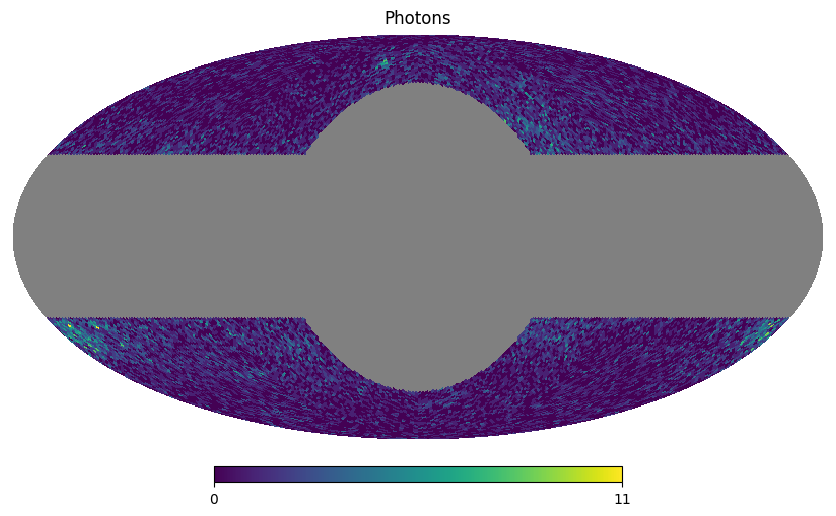

Number of photons in region of interest = 18677


In [141]:
center_mask = 60 #deg
lat_mask = 30 #deg
# N_Ebins = 10
# Ebinspace = 'linear'
# N_countbins = 10
# countbinspace = 'linear'
# mincount, maxcount = 0, 60

N_side = 64
N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

# Generate a heatmap of the photons
heatmap = np.histogram(hp.ang2pix(N_side, photon_info_BG['angles'][:,0], photon_info_BG['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
masked_map = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')), heatmap[0], hp.UNSEEN)
hp.mollview(masked_map, title = 'Photons')
plt.show()

# Compute number of photons in region of interest
photon_pixels = hp.ang2pix(N_side, photon_info_BG['angles'][:, 0], photon_info_BG['angles'][:, 1])
roi_mask = np.isin(photon_pixels, roi_pix_i)
energies_in_roi = photon_info_BG['energies'][roi_mask]
print(f"Number of photons in region of interest = {energies_in_roi.size}")

